### Introduction

This is a demonstration of using Bag of Words NLP method to predict whether the reviewer ultimately recommends the restaurant or not based on his or her comments. The data consists of scraped yelp reviews featuring the individuals' comments and their prescribed recommendation.

In [0]:
# loading required packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from google.colab import files
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

Using TensorFlow backend.


In [0]:
uploaded = files.upload() #train data upload

Saving HW4_Text_train_data.csv to HW4_Text_train_data.csv


In [0]:
df_train = pd.read_csv(io.BytesIO(uploaded['HW4_Text_train_data.csv']))
df_train.head(10)

,Review,Recommended
0,"""go to"" please offer a maxi for mature custome...",1
1,"""go to"" tee for sz 10+ women.Women who want so...",1
2,"""long and warm"".These leg warmers are perfect ...",1
3,"""tweed"" dress.I bought this dress for my siste...",1
4,#1 stunna.I am in lust with this fabulous dres...,1
5,(mostly) good.I have a curvy figure and have a...,1
6,***please restock size 32 in other washes***.T...,1
7,**great for broad shouldered women**.After rea...,1
8,*another* grey cardigan? oh yes....I have too ...,1
9,".$20 for super comfy, warm leggings. bought tw...",1


In [0]:
uploaded2 = files.upload() #test data upload

Saving HW4_Text_test_data.csv to HW4_Text_test_data.csv


In [0]:
df_test = pd.read_csv(io.BytesIO(uploaded2['HW4_Text_test_data.csv']))
df_test.head(10)

,Review,Recommended
0,"""beach business"".Great for the beachy business...",1
1,"""formal pajamas"".These are super comfy and so ...",1
2,"""perfect with jeans"".Great with leggings.perfe...",1
3,"""won't stretch"" tags are misleading.The tag on...",1
4,$200 piece of polyester.A $200 piece of polyes...,0
5,**love**.So glad i was able to snag these kill...,1
6,.#childsize. not sure where this went wrong bu...,0
7,... just not for me....I was very excited to t...,1
8,".A bit wide in the torso, but the detail at th...",1
9,".A little thin, but overall very cute. i like ...",1


In [0]:
Yes_train = df_train.loc[df_train['Recommended']==1]
No_train = df_train.loc[df_train['Recommended']==0]

text_train1 = np.array(Yes_train['Review']) #reviews with positive recommendation
text_train2 = np.array(No_train['Review']) #reviews with negative recommendation

text_train = np.concatenate((text_train1, text_train2 ), axis=0)

In [0]:
y_train1 = np.array(Yes_train['Recommended']),
y_train2 = np.array(No_train['Recommended'])
y_train = np.append(y_train1, y_train2)

In [0]:
Yes_test = df_test.loc[df_test['Recommended']==1]
No_test = df_test.loc[df_test['Recommended']==0]

text_test1 = np.array(Yes_test['Review']) #reviews with positive recommendation
text_test2 = np.array(No_test['Review']) #reviews with negative recommendation

text_test = np.concatenate((text_test1, text_test2 ), axis=0)

In [0]:
y_test1 = np.array(Yes_test['Recommended']),
y_test2 = np.array(No_test['Recommended'])
y_test = np.append(y_test1, y_test2)

In [0]:
# function to plot top positive and negative coefficients
def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))

    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")


In [0]:
# Code chunk for first model of one word (n-grams)
vect = CountVectorizer(ngram_range=(1,1)).fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

In [0]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100],"solver":["liblinear","saga"]}
grid = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.899
Best parameters:  {'C': 0.1, 'solver': 'saga'}


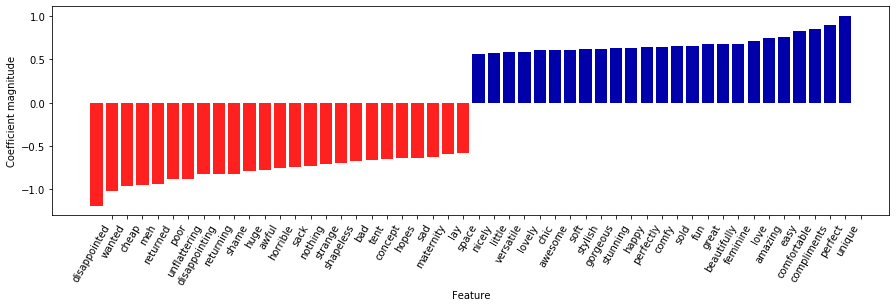

In [0]:
coefs = LogisticRegression(C=0.1,solver='saga',penalty='l2').fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features=25)

In [0]:
y_pred = grid.predict(X_test)
print("AUC score: {:.3f}".format(roc_auc_score(y_test, y_pred)))

AUC score: 0.809


In [0]:
# Code chunk for second model of two word (n-grams)
vect = CountVectorizer(ngram_range=(2,2)).fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

In [0]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100],"solver":["liblinear","saga"]}
grid = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.895
Best parameters:  {'C': 1, 'solver': 'saga'}


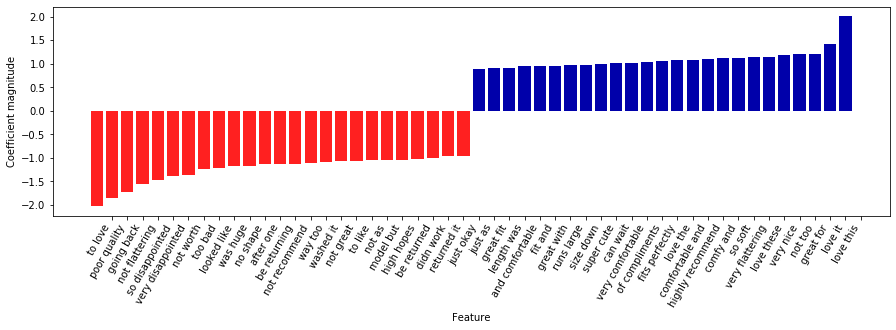

In [0]:
coefs = LogisticRegression(C=1,solver='saga',penalty='l2').fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features=25)

In [0]:
y_pred = grid.predict(X_test)
print("AUC score: {:.3f}".format(roc_auc_score(y_test, y_pred)))

AUC score: 0.801


In [0]:
# Code chunk for third model of three word (n-grams)
vect = CountVectorizer(ngram_range=(3,3)).fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

In [0]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100],"solver":["liblinear","saga"]}
grid = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.872
Best parameters:  {'C': 100, 'solver': 'saga'}


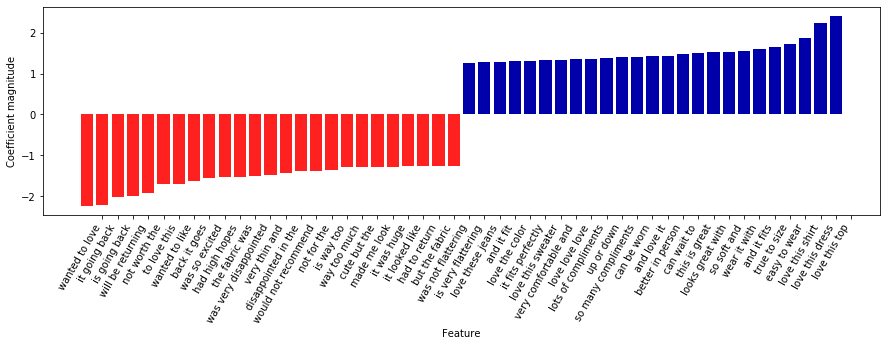

In [0]:
coefs = LogisticRegression(C=100,solver='saga',penalty='l2').fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features=25)

In [0]:
y_pred = grid.predict(X_test)
print("AUC score: {:.3f}".format(roc_auc_score(y_test, y_pred)))

AUC score: 0.697


In [0]:
# Code chunk for fourth model of one - three word (n-grams)
vect = CountVectorizer(ngram_range=(1,3)).fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

In [0]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100],"solver":["liblinear","saga"]}
grid = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.908
Best parameters:  {'C': 100, 'solver': 'saga'}


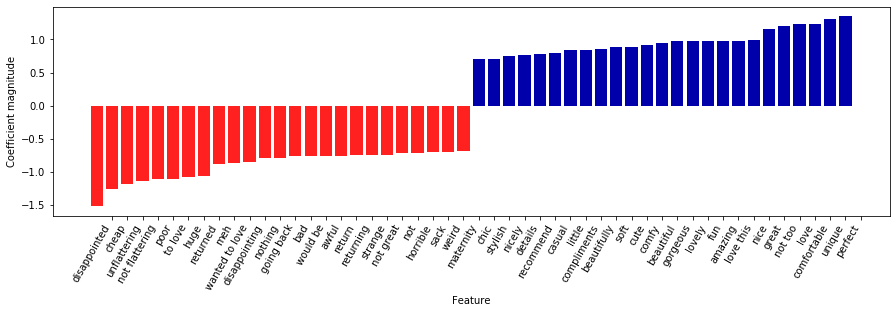

In [0]:
coefs = LogisticRegression(C=100,solver='saga',penalty='l2').fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features=25)

In [0]:
y_pred = grid.predict(X_test)
print("AUC score: {:.3f}".format(roc_auc_score(y_test, y_pred)))

AUC score: 0.831


I, first, implemented a logistic regression with different n grams. The first model has a single word (1-gram feature). The second model has two words (2-gram features). The third model has a three words (3-gram features). The last model has a n gram of one to three words (1-3 gram features). 
<br>
<br>
The relevant parameters of every model has been optimally tuned using GridSearchCV based on the training set, and the cross-validation was used to evaluate the results. Then, the top positive and negative coefficients are visualized on a plot. Finally, the model is then evaluated on a test set using the AUC score.
<br>
<br>
AUC score was selected because it is suitable for imbalanced classification. It is not scale variant, in which it measures predictive power based on rank and not absolute values. Moreover, it does not depend on the classification threshold. In other words, AUC gives an aggregate score of the quality of the prediction across all possible classification thresholds. It can be interpreted as the probabiltiy of ranking a positive more highly than a negative.
<br>
<br>
Model 1
<br>
Cross validation score: 0.899
<br>
ROC_AUC score: 0.809
<br>
<br>
Model 2:
<br>
Cross validation score: 0.896
<br>
ROC_AUC score: 0.801
<br>
<br>
Model 3:
<br>
Cross validation score: 0.872
<br>
ROC_AUC score: 0.697
<br>
<br>
Model 4:
<br>
Cross validation score: 0.908
<br>
ROC_AUC score: 0.831
<br>
<br>
Based on the evaluation, it is interesting to note that both the cross validation score and AUC score decreased as the number of words used for the counter vectorizer increased. However, this was not the case for model four, which used a range of one word to three words. In fact, model 4 scored the highest on both its cross validation score and AUC score. With that in mind, model 4 is the best model in relation to other models. The results make senese because more options or flexbility of words are more likley to translate to higher predictive power.